In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cvxpy as cp

In [2]:
df = pd.read_csv('../data/surgeries.csv', index_col=0)
df = df.iloc[:40, :]

In [3]:
df['start'] = pd.to_datetime(df['start'])
df['end'] = pd.to_datetime(df['end'])
df['duration'] = (df['end'] - df['start']).dt.total_seconds() / 60

In [4]:
min_time = df['start'].min()
df = df.assign(
    rel_start=(df['start'] - min_time).dt.total_seconds() / 60,
    rel_end=(df['end'] - min_time).dt.total_seconds() / 60
)

In [5]:
print(df)

                 start                 end  duration  rel_start  rel_end
0  2023-04-25 07:00:00 2023-04-25 07:15:00      15.0        0.0     15.0
1  2023-04-25 07:00:00 2023-04-25 07:30:00      30.0        0.0     30.0
2  2023-04-25 07:00:00 2023-04-25 07:30:00      30.0        0.0     30.0
3  2023-04-25 07:00:00 2023-04-25 07:30:00      30.0        0.0     30.0
4  2023-04-25 07:00:00 2023-04-25 07:45:00      45.0        0.0     45.0
5  2023-04-25 07:00:00 2023-04-25 08:00:00      60.0        0.0     60.0
6  2023-04-25 07:00:00 2023-04-25 08:45:00     105.0        0.0    105.0
7  2023-04-25 07:00:00 2023-04-25 09:45:00     165.0        0.0    165.0
8  2023-04-25 07:15:00 2023-04-25 07:30:00      15.0       15.0     30.0
9  2023-04-25 07:15:00 2023-04-25 07:30:00      15.0       15.0     30.0
10 2023-04-25 07:15:00 2023-04-25 08:00:00      45.0       15.0     60.0
11 2023-04-25 07:15:00 2023-04-25 09:30:00     135.0       15.0    150.0
12 2023-04-25 07:30:00 2023-04-25 07:45:00      15.

# Use CVXPY integer programming to solve this assignment problem

In [6]:
num_of_intervals = len(df)
num_of_rooms = 20
num_of_doctors = num_of_intervals # at the worst case - each surgery needs a different doctor

In [7]:
rooms = np.arange(1, num_of_rooms + 1)
doctors = np.arange(1, num_of_doctors + 1)

In [8]:
overlaps = list()
for i in range(num_of_intervals):
    for j in range(i + 1, num_of_intervals):
        if df.iloc[j]['rel_start'] < df.iloc[i]['rel_end']:
            overlaps.append((i, j))

In [9]:
shift_overlaps = list()
for i in range(num_of_intervals):
    for j in range(i + 1, num_of_intervals):
        if df.iloc[j]['rel_start'] < df.iloc[i]['rel_end'] + 15:
            shift_overlaps.append((i, j))

In [10]:
M = 1 + max(num_of_doctors, num_of_rooms)
m = -M

In [11]:
# doctor-surgery assignment
D = cp.Variable((num_of_doctors, num_of_intervals), boolean=True)

# room-surgery assignment
R = cp.Variable((num_of_rooms, num_of_intervals), boolean=True)

# integer variables for the constraints meaning that for two 15-min overlapping surgeries,
#    different rooms --> different doctors
# since according to the requirements it cannot be the same doctor. Equivalently, we can write
#    same doctor --> same room
#
# In the language of our decision variables, the implication reads:
#   doc_per_surgery[j1] - doc_per_surgery[j2] = 0 ==> room_per_surgery[j1] - room_per_surgery[j2] = 0
# We will model a pair of integer variables, one for the LHS equality, and one for the RHS equality,
# and require that for shift-overlapping surgeries same_room[idx, 0] >= same_doc[idx, 0] (same doctor implies same room)
# same_room[:, 1:2] and same_doc[:, 1:2] are helper variables required to model same_room[:, 0] and same_doc[:, 0]
same_room = cp.Variable((len(shift_overlaps), 3), boolean=True)
same_doc = cp.Variable((len(shift_overlaps), 3), boolean=True)

constraints = []
constraints.append(cp.sum(D, axis=0) == 1) # each surgery has exactly one doctor
constraints.append(cp.sum(R, axis=0) == 1) # each surgery has exactly one room
for j1, j2 in overlaps:
    constraints.append(D[:, j1] + D[:, j2] <= 1) # no doctor can be in two surgeries at the same time
    constraints.append(R[:, j1] + R[:, j2] <= 1) # no room can host two surgeries at the same time


doc_per_surgery = doctors @ D
room_per_surgery = rooms @ R
for idx, (j1, j2) in enumerate(shift_overlaps):
    def make_indicator_of_zero(value, ind, ind_plus, ind_minus):
        # credit - this answer: https://or.stackexchange.com/questions/9163/how-to-model-logic-constraint-y-1-if-a-le-x-le-b-and-y-0-otherwise?noredirect=1&lq=1
        constraints.append(value <= -0.5 * ind_minus + 0.5 * ind + M * ind_plus)
        constraints.append(-M * ind_minus + -0.5 * ind + 0.5 * ind_plus <= value)
        constraints.append(ind_minus + ind + ind_plus == 1)

    room_diff = room_per_surgery[j1] - room_per_surgery[j2]
    make_indicator_of_zero(room_diff, same_room[idx, 0], same_room[idx, 1], same_room[idx, 2])

    doc_diff = doc_per_surgery[j1] - doc_per_surgery[j2]
    make_indicator_of_zero(doc_diff, same_doc[idx, 0], same_doc[idx, 1], same_doc[idx, 2])

    constraints.append(same_room[idx, 0] >= same_doc[idx, 0])

objective = cp.Minimize(cp.max(doc_per_surgery))
problem = cp.Problem(objective, constraints)

In [12]:
problem.solve()

13.0

In [13]:
problem.solution.status

'optimal'

In [14]:
print(f'Optimal value: {problem.value}')

Optimal value: 13.0


<Axes: >

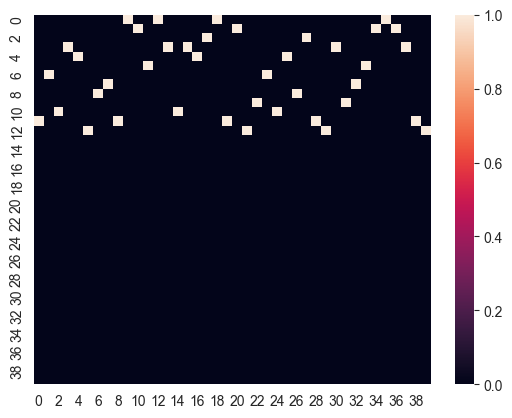

In [15]:
sns.heatmap(D.value)

<Axes: >

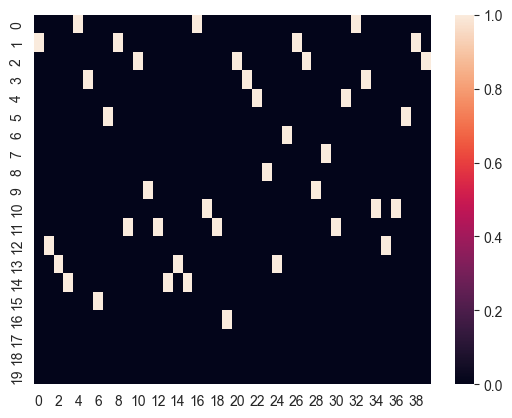

In [16]:
sns.heatmap(R.value)

In [17]:
opt_room_per_surgery = rooms @ R.value
opt_doc_per_surgery = doctors @ D.value

In [18]:
print(opt_room_per_surgery)

[ 2. 13. 14. 15.  1.  4. 16.  6.  2. 12.  3. 10. 12. 15. 14. 15.  1. 11.
 12. 17.  3.  4.  5.  9. 14.  7.  2.  3. 10.  8. 12.  5.  1.  4. 11. 13.
 11.  6.  2.  3.]


In [19]:
print(opt_doc_per_surgery)

[12.  7. 11.  4.  5. 13.  9.  8. 12.  1.  2.  6.  1.  4. 11.  4.  5.  3.
  1. 12.  2. 13. 10.  7. 11.  5.  9.  3. 12. 13.  4. 10.  8.  6.  2.  1.
  2.  4. 12. 13.]


In [20]:
# for debugging - make sure that the same_room variable is computed correctly.
for idx, (j1, j2) in enumerate(shift_overlaps):
    if same_room[idx, 0].value > 0.5:
        print(f'same_room[idx] = {same_room[idx, 0].value} ==> Room {opt_room_per_surgery[j1]} and room {opt_room_per_surgery[j2]} are used for 15-min overlapping surgeries {j1} and {j2}')

    if opt_room_per_surgery[j1] == opt_room_per_surgery[j2]:
        print(f'Room {opt_room_per_surgery[j1]} and room {opt_room_per_surgery[j2]} are used for 15-min overlapping surgeries {j1} and {j2} ==> same_room[idx] = {same_room[idx, 0].value}')

same_room[idx] = 1.0 ==> Room 2.0 and room 2.0 are used for 15-min overlapping surgeries 0 and 8
Room 2.0 and room 2.0 are used for 15-min overlapping surgeries 0 and 8 ==> same_room[idx] = 1.0
same_room[idx] = 1.0 ==> Room 14.0 and room 14.0 are used for 15-min overlapping surgeries 2 and 14
Room 14.0 and room 14.0 are used for 15-min overlapping surgeries 2 and 14 ==> same_room[idx] = 1.0
same_room[idx] = 1.0 ==> Room 15.0 and room 15.0 are used for 15-min overlapping surgeries 3 and 13
Room 15.0 and room 15.0 are used for 15-min overlapping surgeries 3 and 13 ==> same_room[idx] = 1.0
same_room[idx] = 1.0 ==> Room 1.0 and room 1.0 are used for 15-min overlapping surgeries 4 and 16
Room 1.0 and room 1.0 are used for 15-min overlapping surgeries 4 and 16 ==> same_room[idx] = 1.0
same_room[idx] = 1.0 ==> Room 4.0 and room 4.0 are used for 15-min overlapping surgeries 5 and 21
Room 4.0 and room 4.0 are used for 15-min overlapping surgeries 5 and 21 ==> same_room[idx] = 1.0
same_room[idx]

In [21]:
# for debugging - make sure that the same_doc variable is computed correctly.
for idx, (j1, j2) in enumerate(shift_overlaps):
    if same_doc[idx, 0].value > 0.5:
        print(f'same_doc[idx] = {same_doc[idx, 0].value} ==> Doc {opt_doc_per_surgery[j1]} and doc {opt_doc_per_surgery[j2]} are in 15-min overlapping surgeries {j1} and {j2}')

    if opt_doc_per_surgery[j1] == opt_doc_per_surgery[j2]:
        print(f'Doc {opt_doc_per_surgery[j1]} and doc {opt_doc_per_surgery[j2]} are in 15-min overlapping surgeries {j1} and {j2} ==> same_doc[idx] = {same_doc[idx, 0].value}')

same_doc[idx] = 1.0 ==> Doc 12.0 and doc 12.0 are in 15-min overlapping surgeries 0 and 8
Doc 12.0 and doc 12.0 are in 15-min overlapping surgeries 0 and 8 ==> same_doc[idx] = 1.0
same_doc[idx] = 1.0 ==> Doc 11.0 and doc 11.0 are in 15-min overlapping surgeries 2 and 14
Doc 11.0 and doc 11.0 are in 15-min overlapping surgeries 2 and 14 ==> same_doc[idx] = 1.0
same_doc[idx] = 1.0 ==> Doc 4.0 and doc 4.0 are in 15-min overlapping surgeries 3 and 13
Doc 4.0 and doc 4.0 are in 15-min overlapping surgeries 3 and 13 ==> same_doc[idx] = 1.0
same_doc[idx] = 1.0 ==> Doc 5.0 and doc 5.0 are in 15-min overlapping surgeries 4 and 16
Doc 5.0 and doc 5.0 are in 15-min overlapping surgeries 4 and 16 ==> same_doc[idx] = 1.0
same_doc[idx] = 1.0 ==> Doc 13.0 and doc 13.0 are in 15-min overlapping surgeries 5 and 21
Doc 13.0 and doc 13.0 are in 15-min overlapping surgeries 5 and 21 ==> same_doc[idx] = 1.0
same_doc[idx] = 1.0 ==> Doc 1.0 and doc 1.0 are in 15-min overlapping surgeries 9 and 12
Doc 1.0 and